In [1]:
import os
import pandas as pd

In [2]:
# Create a Subset Data
# Load the datasets
train_data = pd.read_csv('data/train_data.csv', nrows=50000)
train_labels = pd.read_csv('data/train_labels.csv')

# Merge the datasets on 'customer_ID'
merged_data = pd.merge(train_data, train_labels, on='customer_ID')

# Export the subset to a new CSV file
merged_data.to_csv('data/subset_train_data.csv', index=False)

### For each customer_ID in the test set, you must predict a probability for the target variable. The file should contain a header and have the following format:   
customer_ID,prediction  
00000469ba...,0.01  
00001bf2e7...,0.22  
0000210045...,0.98  
etc.
  

The objective of this competition is to predict the probability that a customer does not pay back their credit card balance amount in the future based on their monthly customer profile. The target binary variable is calculated by observing 18 months performance window after the latest credit card statement, and if the customer does not pay due amount in 120 days after their latest statement date it is considered a default event.

The dataset contains aggregated profile features for each customer at each statement date. Features are anonymized and normalized, and fall into the following general categories:
- D_* = Delinquency variables
- S_* = Spend variables
- P_* = Payment variables
- B_* = Balance variables
- R_* = Risk variables

with the following features being categorical:
['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

Your task is to predict, for each customer_ID, the probability of a future payment default (target = 1).

Note that the negative class has been subsampled for this dataset at 5%, and thus receives a 20x weighting in the scoring metric.

### Evaluation
The evaluation metric, 𝑀, for this competition is the mean of two measures of rank ordering:  
Normalized Gini Coefficient, 𝐺, and default rate captured at 4%, 𝐷.  

$𝑀=0.5⋅(𝐺+𝐷)$  

The default rate captured at 4% is the percentage of the positive labels (defaults) captured within the highest-ranked 4% of the predictions, and represents a Sensitivity/Recall statistic.  

For both of the sub-metrics 𝐺 and 𝐷, the negative labels are given a weight of 20 to adjust for downsampling.  
This metric has a maximum value of 1.0.  

Python code for calculating this metric can be found in  
https://www.kaggle.com/code/inversion/amex-competition-metric-python

In [3]:
# Reading Subset data
train_data_subset = pd.read_csv('data/subset_train_data.csv')

In [4]:
pd.set_option('display.max_info_columns', 200)
train_data_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 191 columns):
 #    Column       Non-Null Count  Dtype  
---   ------       --------------  -----  
 0    customer_ID  50000 non-null  object 
 1    S_2          50000 non-null  object 
 2    P_2          49608 non-null  float64
 3    D_39         50000 non-null  float64
 4    B_1          50000 non-null  float64
 5    B_2          49986 non-null  float64
 6    R_1          50000 non-null  float64
 7    S_3          40257 non-null  float64
 8    D_41         49986 non-null  float64
 9    B_3          49986 non-null  float64
 10   D_42         7037 non-null   float64
 11   D_43         34622 non-null  float64
 12   D_44         47464 non-null  float64
 13   B_4          50000 non-null  float64
 14   D_45         49986 non-null  float64
 15   B_5          50000 non-null  float64
 16   R_2          50000 non-null  float64
 17   D_46         38922 non-null  float64
 18   D_47         50000 non-n

In [5]:
train_data_subset["customer_ID"].nunique()

4154

In [6]:
categorical = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

In [7]:
train_data_subset[['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']]

,B_30,B_38,D_114,D_116,D_117,D_120,D_126,D_63,D_64,D_66,D_68
0,0.0,2.0,1.0,0.0,4.0,0.0,1.0,CR,O,NaN,6.0
1,0.0,2.0,1.0,0.0,4.0,0.0,1.0,CR,O,NaN,6.0
2,0.0,2.0,1.0,0.0,4.0,0.0,1.0,CR,O,NaN,6.0
3,0.0,2.0,1.0,0.0,4.0,0.0,1.0,CR,O,NaN,6.0
4,0.0,2.0,1.0,0.0,4.0,0.0,1.0,CR,O,NaN,6.0
...,...,...,...,...,...,...,...,...,...,...,...
49995,0.0,1.0,1.0,0.0,3.0,0.0,1.0,CO,O,NaN,6.0
49996,0.0,1.0,1.0,0.0,3.0,0.0,1.0,CO,O,NaN,6.0
49997,0.0,1.0,1.0,0.0,3.0,0.0,1.0,CO,O,NaN,6.0
49998,0.0,1.0,1.0,0.0,3.0,0.0,1.0,CO,O,NaN,6.0


In [8]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
from tqdm import tqdm

def denoise(df):
    df['D_63'] = df['D_63'].apply(lambda t: {'CR':0, 'XZ':1, 'XM':2, 'CO':3, 'CL':4, 'XL':5}[t]).astype(np.int8)
    df['D_64'] = df['D_64'].apply(lambda t: {np.nan:-1, 'O':0, '-1':1, 'R':2, 'U':3}[t]).astype(np.int8)
    for col in tqdm(df.columns):
        if col not in ['customer_ID','S_2','D_63','D_64']:
            df[col] = np.floor(df[col]*100)
    return df

data = denoise(train_data_subset)

100%|███████████████████████████████████████| 191/191 [00:00<00:00, 2075.41it/s]


In [9]:
pd.set_option('display.max_rows', None)
print(data.dtypes)

customer_ID     object
S_2             object
P_2            float64
D_39           float64
B_1            float64
B_2            float64
R_1            float64
S_3            float64
D_41           float64
B_3            float64
D_42           float64
D_43           float64
D_44           float64
B_4            float64
D_45           float64
B_5            float64
R_2            float64
D_46           float64
D_47           float64
D_48           float64
D_49           float64
B_6            float64
B_7            float64
B_8            float64
D_50           float64
D_51           float64
B_9            float64
R_3            float64
D_52           float64
P_3            float64
B_10           float64
D_53           float64
S_5            float64
B_11           float64
S_6            float64
D_54           float64
R_4            float64
S_7            float64
B_12           float64
S_8            float64
D_55           float64
D_56           float64
B_13           float64
R_5        

## 1. Explatory Data Analysis

In [10]:
summary_statistics = train_data_subset.describe()
summary_statistics

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
count,49608.000000,50000.00000,50000.000000,49986.000000,50000.00000,40257.000000,49986.000000,49986.000000,7037.000000,34622.000000,...,1948.000000,1948.000000,49132.000000,49659.000000,49132.000000,8141.000000,49132.000000,49659.000000,49132.000000,50000.000000
mean,65.332628,14.65262,12.208640,61.271896,7.33766,22.065430,5.380647,12.846057,17.727014,15.597510,...,1.283368,18.249487,16.569649,2.070118,15.236384,38.728289,16.526907,4.776153,5.168912,25.902000
std,24.688188,26.66418,21.799056,40.157634,22.65217,19.539106,19.323226,23.515508,22.527422,24.588314,...,11.258543,28.565523,37.181175,14.238347,34.257314,24.725478,37.142700,18.481842,18.833647,43.810099
min,-39.000000,0.00000,-15.000000,0.000000,0.00000,-23.000000,0.000000,0.000000,-1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-2.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.00000,0.000000,10.000000,0.00000,12.000000,0.000000,0.000000,3.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000
50%,70.000000,0.00000,3.000000,81.000000,0.00000,16.000000,0.000000,0.000000,12.000000,8.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,37.000000,0.000000,0.000000,0.000000,0.000000
75%,86.000000,21.00000,12.000000,100.000000,0.00000,25.000000,0.000000,16.000000,24.000000,18.000000,...,0.000000,50.000000,0.000000,0.000000,0.000000,56.000000,0.000000,0.000000,0.000000,100.000000
max,100.000000,500.00000,132.000000,100.000000,250.00000,258.000000,475.000000,139.000000,268.000000,908.000000,...,100.000000,150.000000,100.000000,100.000000,117.000000,175.000000,100.000000,134.000000,428.000000,100.000000


## 1.1. Data preprocessing
### a. Handling missing values

In [11]:
from sklearn.impute import SimpleImputer

# Remove Columns with High Percentage of Missing Values
# Define a threshold for dropping columns (e.g., 50% missing values)
threshold = 0.5

# Drop columns with missing value rate higher than threshold
train_data_subset = train_data_subset[train_data_subset.columns[train_data_subset.isnull().mean() < threshold]]


# For Numerical Columns
# Impute numerical columns using the mean value
num_imputer = SimpleImputer(strategy='mean')

# Assuming your numerical columns are of types 'float64' or 'int64'
numerical_cols = train_data_subset.select_dtypes(include=['float64', 'int64']).columns

train_data_subset[numerical_cols] = num_imputer.fit_transform(train_data_subset[numerical_cols])

# For Categorical Columns
# Impute categorical columns using the most frequent value
cat_imputer = SimpleImputer(strategy='most_frequent')

# Assuming your categorical columns are of type 'object'
categorical_cols = train_data_subset.select_dtypes(include=['object']).columns

train_data_subset[categorical_cols] = cat_imputer.fit_transform(train_data_subset[categorical_cols])

### b. Normalization

In [12]:
# Standardization
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the dataset
# Note: You might want to exclude non-numeric or categorical columns
standardized_data = scaler.fit_transform(train_data_subset.select_dtypes(include=['float64', 'int64']))

# Convert the array back to a DataFrame
standardized_data = pd.DataFrame(standardized_data, columns=train_data_subset.select_dtypes(include=['float64', 'int64']).columns)

# Normalization
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
min_max_scaler = MinMaxScaler()

# Fit and transform the dataset
# Note: Exclude non-numeric or categorical columns as needed
normalized_data = min_max_scaler.fit_transform(train_data_subset.select_dtypes(include=['float64', 'int64']))

# Convert the array back to a DataFrame
normalized_data = pd.DataFrame(normalized_data, columns=train_data_subset.select_dtypes(include=['float64', 'int64']).columns)

### c. Outliers

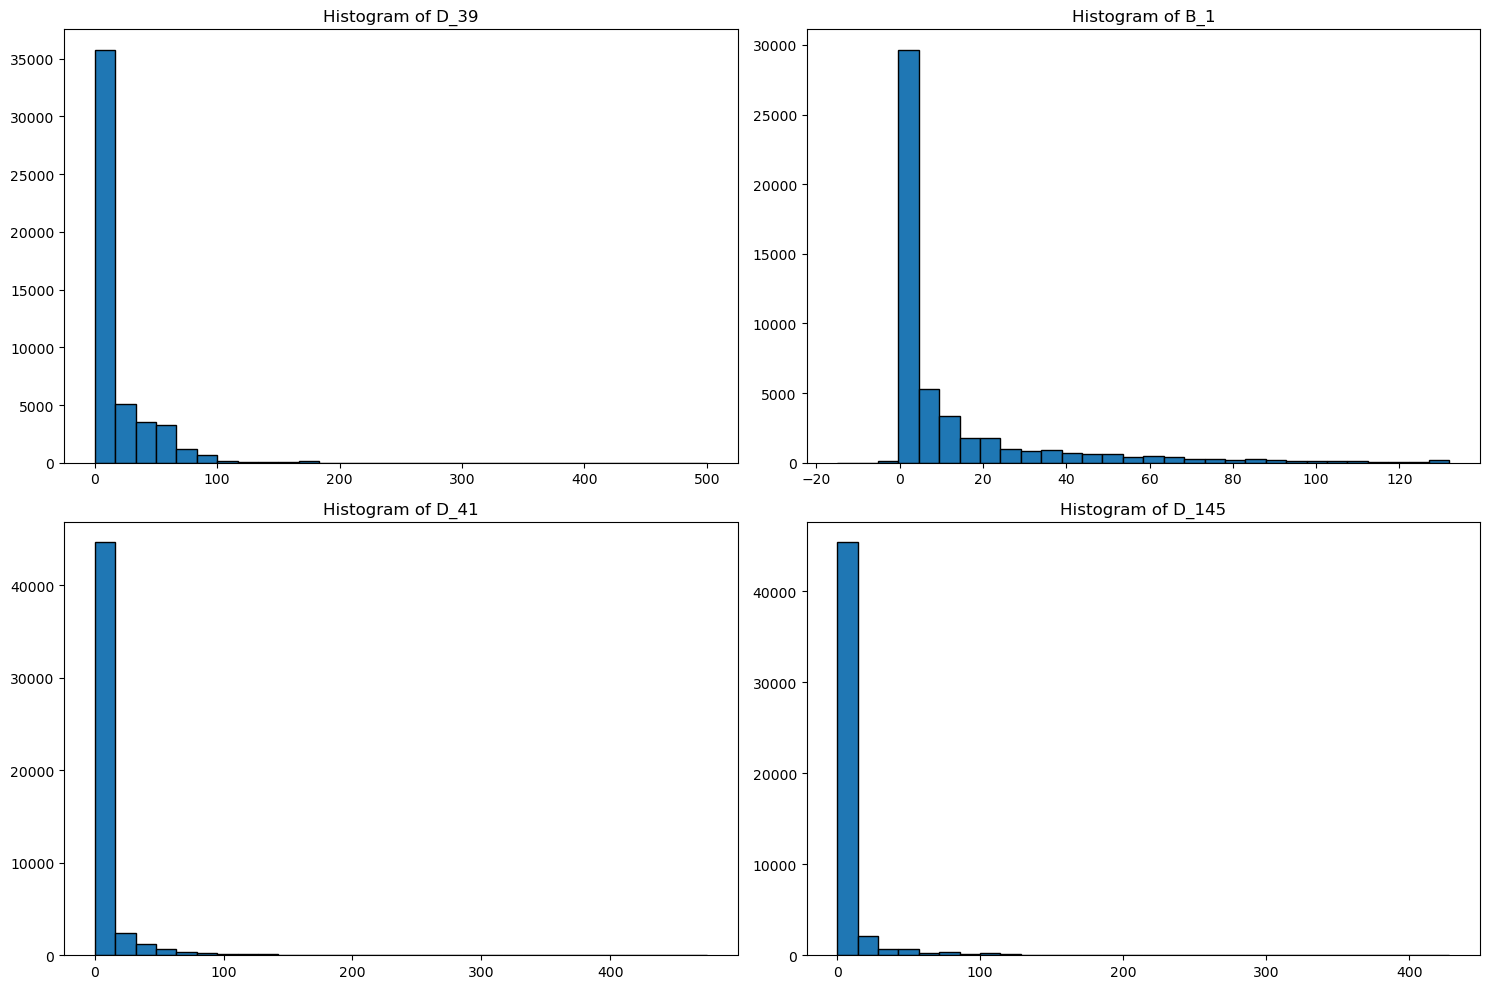

In [13]:
import matplotlib.pyplot as plt

sample_columns = ['D_39', 'B_1', 'D_41', 'D_145']

# Create a figure for histograms
plt.figure(figsize=(15, 10))
for i, col in enumerate(sample_columns):
    plt.subplot(2, 2, i+1)
    plt.hist(train_data_subset[col], bins=30, edgecolor='black')
    plt.title(f'Histogram of {col}')
plt.tight_layout()
plt.show()


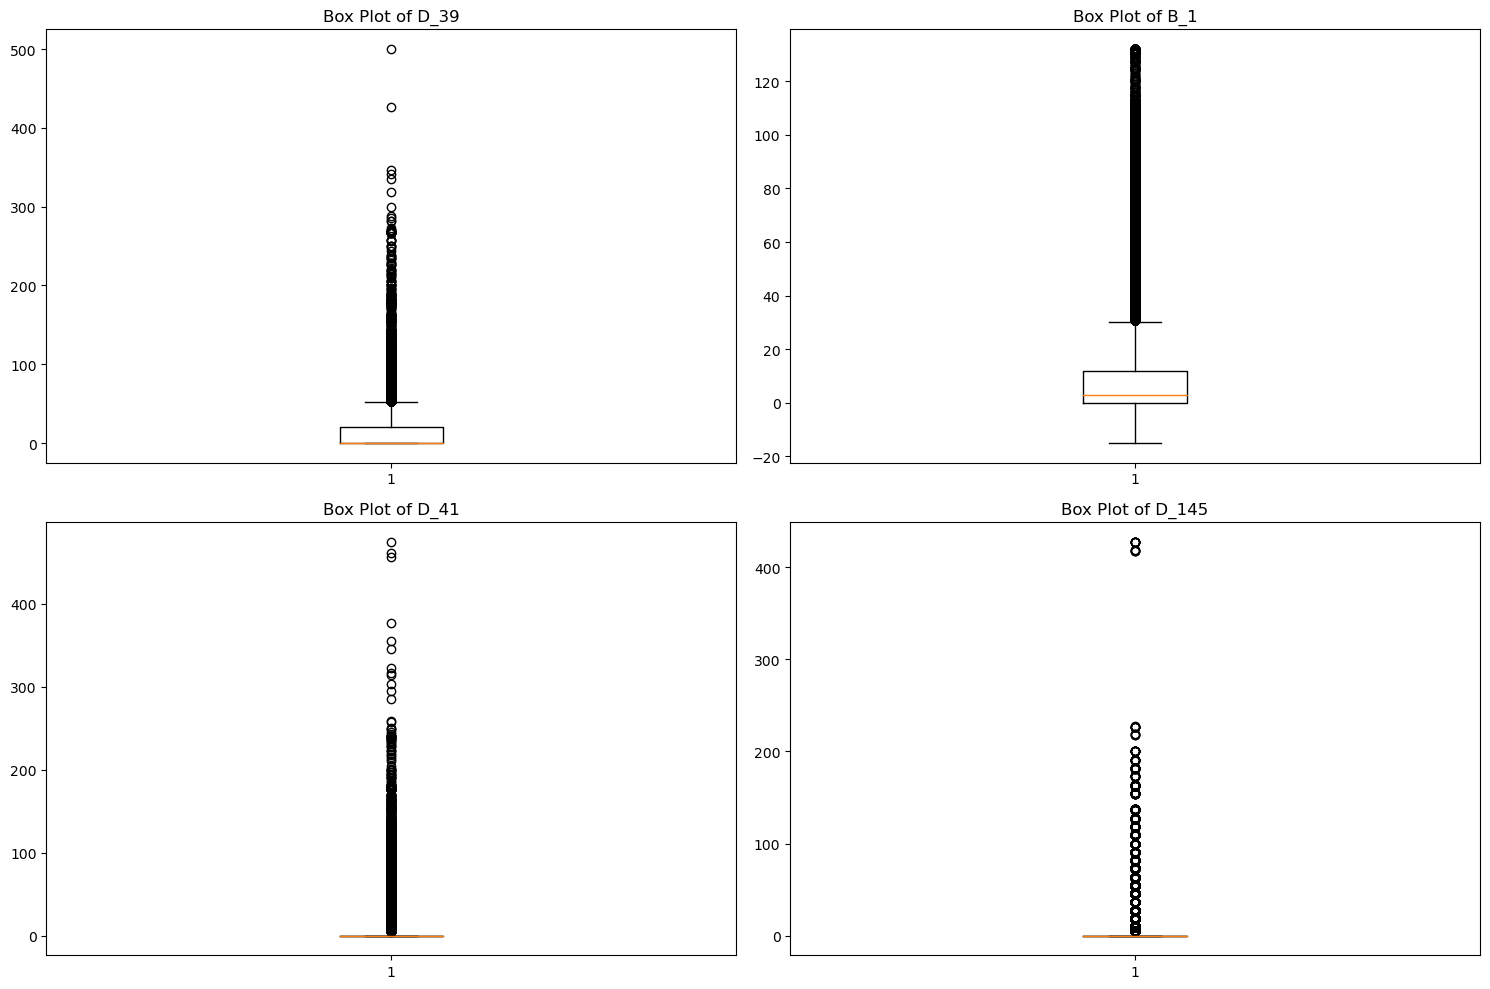

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

sample_columns = ['D_39', 'B_1', 'D_41', 'D_145']

# Create a figure for box plots
plt.figure(figsize=(15, 10))
for i, col in enumerate(sample_columns):
    plt.subplot(2, 2, i+1)
    plt.boxplot(train_data_subset[col].dropna())  # Using dropna() to remove NaN values
    plt.title(f'Box Plot of {col}')
plt.tight_layout()
plt.show()


### d. Robust scaling

In [15]:
from sklearn.preprocessing import RobustScaler

# Initialize the RobustScaler
robust_scaler = RobustScaler()

# Select the columns to scale
columns_to_scale = ['D_39', 'B_1', 'D_41', 'D_145']  # Replace with actual columns as needed

# Fit and transform the columns with the RobustScaler
train_data_subset[columns_to_scale] = robust_scaler.fit_transform(train_data_subset[columns_to_scale])

# Show the scaled data
train_data_subset[columns_to_scale].head()


,D_39,B_1,D_41,D_145
0,0.000000,-0.250000,0.0,0.0
1,0.000000,-0.250000,0.0,0.0
2,0.428571,-0.083333,0.0,0.0
3,0.000000,-0.166667,0.0,0.0
4,0.000000,-0.166667,0.0,0.0


### 1.2. Feature engineering

### a. Interaction features:

In [16]:
# Convert columns to numeric, setting errors='coerce' will convert non-numeric values to NaN
for col in train_data_subset.filter(regex='^(D_|S_|P_|B_)'):
    train_data_subset[col] = pd.to_numeric(train_data_subset[col], errors='coerce')
    
# Delinquency Features
train_data_subset['delinquency_count'] = train_data_subset.filter(regex='^D_').gt(0).sum(axis=1)
train_data_subset['delinquency_severity'] = train_data_subset.filter(regex='^D_').max(axis=1)

# Spend Features
train_data_subset['total_spend_recent'] = train_data_subset.filter(regex='^S_').sum(axis=1)
train_data_subset['average_monthly_spend'] = train_data_subset.filter(regex='^S_').mean(axis=1)

# Payment Features
train_data_subset['average_payment'] = train_data_subset.filter(regex='^P_').mean(axis=1)
train_data_subset['payment_consistency'] = train_data_subset.filter(regex='^P_').std(axis=1)

### b. Aggregate features

In [89]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


# Identify numerical and categorical columns again
numerical_cols = train_data_subset.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = train_data_subset.select_dtypes(include=['object', 'category']).columns.tolist()

# Impute and Scale Numerical Columns
for col in numerical_cols:
    # Handle missing values for each numerical column
    train_data_subset[col] = SimpleImputer(strategy='mean').fit_transform(train_data_subset[[col]])

    # Scale each numerical column
    train_data_subset[col] = StandardScaler().fit_transform(train_data_subset[[col]])

# Encode Categorical Columns
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoded_cats = encoder.fit_transform(train_data_subset[categorical_cols])
encoded_cats_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_cols))

# Concatenate the encoded features with the original dataset
train_data_subset = pd.concat([train_data_subset, encoded_cats_df], axis=1)

# Drop the original categorical columns as they are now encoded
train_data_subset.drop(columns=categorical_cols, inplace=True)

# Print a message to indicate successful execution
print("Data preprocessing completed successfully.")


Data preprocessing completed successfully.


### c. Dimensionality reduction

Number of Features: 4320


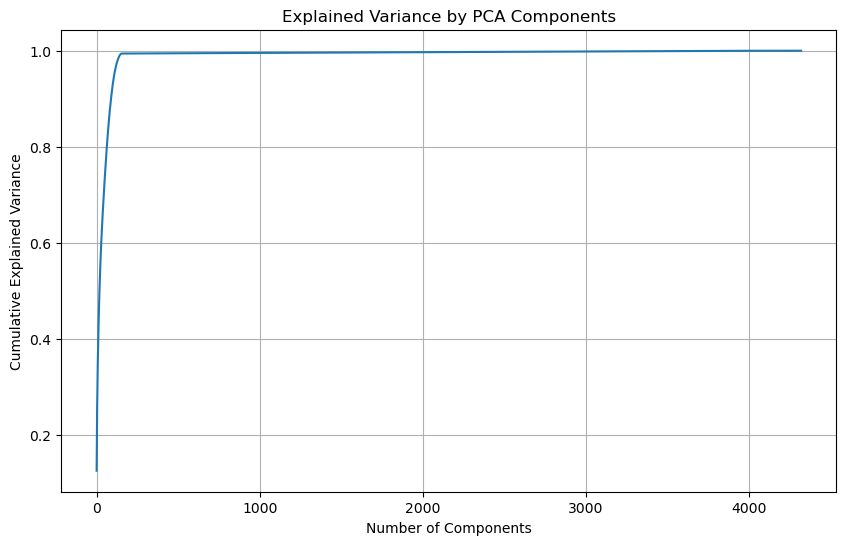

Number of components that explain 95% of variance: 109
PCA may be beneficial.


In [18]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

num_features = train_data_subset.shape[1]
print(f"Number of Features: {num_features}")

# Impute missing values using the mean of each column
imputer = SimpleImputer(strategy='mean')
train_data_imputed = imputer.fit_transform(train_data_subset)

# Now apply PCA to the imputed data
pca = PCA()
pca.fit(train_data_imputed)

# Check the variance explained by each component
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(cumulative_explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()

# Determine the number of components that explain a significant amount of variance, e.g., 95%
n_components_95 = np.argmax(cumulative_explained_variance >= 0.95) + 1
print(f"Number of components that explain 95% of variance: {n_components_95}")

# Decision criteria
num_features = train_data_subset.shape[1]
if num_features > 50 or n_components_95 < num_features * 0.8:
    print("PCA may be beneficial.")
else:
    print("PCA may not be necessary.")


### d. Data splitting

In [57]:
from sklearn.model_selection import train_test_split

# Separate features and target variable
X = train_data_subset.drop('target', axis=1)
y = train_data_subset['target']

# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


## 2. Model selection

### 2.1. Logistic regression

### 2.1.a. Hyperparameter tuning

In [58]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Binarizer  # Import Binarizer

# Convert y_train to binary
y_train_binary = Binarizer(threshold=0.5).fit_transform(y_train.values.reshape(-1, 1)).ravel()

# Create a pipeline with an imputer and logistic regression
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values
    ('logistic_regression', LogisticRegression())
])

# Define the parameter grid
param_grid_lr = {
    'logistic_regression__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logistic_regression__solver': ['newton-cg', 'lbfgs', 'liblinear']
}

# Initialize Grid Search
grid_search_lr = GridSearchCV(estimator=pipeline, param_grid=param_grid_lr, cv=5, scoring='roc_auc')

# Assuming X_train and y_train_binary are already defined and ready to be used
# Fit the grid search to the data
grid_search_lr.fit(X_train, y_train_binary)

# Print a success message
print("Grid search completed successfully!")

Grid search completed successfully!


### 2.1.b. Best model evaluation

Test AUC: 0.9998699841073225
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     11094
         1.0       0.99      1.00      0.99      3906

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000



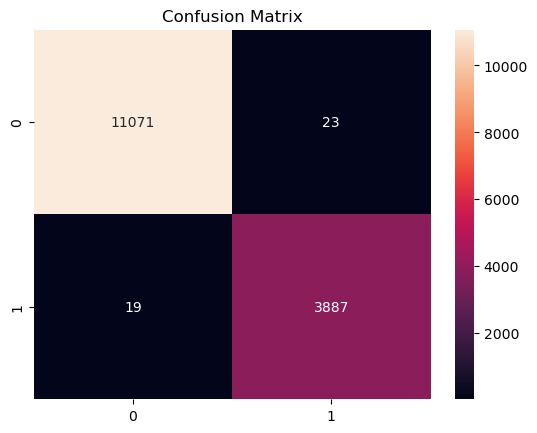

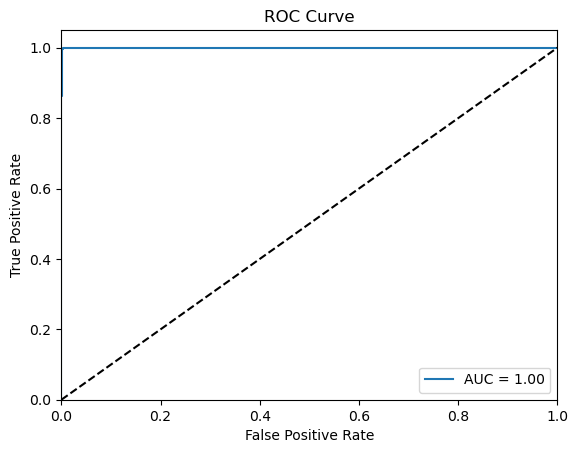

In [59]:
from sklearn.preprocessing import Binarizer

# Convert y_test to binary
binarizer = Binarizer(threshold=0.5)
y_test_binary = binarizer.fit_transform(y_test.values.reshape(-1, 1)).ravel()

# Get the best model
best_model = grid_search_lr.best_estimator_

# Predict on the test data
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate AUC using the binary version of y_test
auc = roc_auc_score(y_test_binary, y_pred_proba)
print(f'Test AUC: {auc}')

# Generate a classification report using the binary version of y_test
print(classification_report(y_test_binary, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test_binary, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC curve
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test_binary, y_pred_proba)
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


### 2.1.c. Cross-validation

In [85]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

# Separate features and target
X = train_data_subset.drop('target', axis=1)
y = train_data_subset['target']

# Convert target to binary using LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Create an imputer object with a mean filling strategy
imputer = SimpleImputer(strategy='mean')

# Impute the missing values in X
X_imputed = imputer.fit_transform(X)

# Initialize the classifier
clf = RandomForestClassifier(n_estimators=100)

# Perform cross-validation
cv_scores = cross_val_score(clf, X_imputed, y_encoded, cv=5, scoring='roc_auc')

# Print the AUC scores for each fold
print("AUC scores for each fold are:", cv_scores)


AUC scores for each fold are: [0.93459684 0.92189254 0.92726799 0.92407174 0.92034905]


### 2.1.d. Model evaluation on a test set

In [87]:
from sklearn.preprocessing import Binarizer

# Convert y_test to binary if it's not already
binarizer = Binarizer(threshold=0.5)
y_test_binary = binarizer.fit_transform(y_test.values.reshape(-1, 1)).ravel()

# Make predictions using the best model
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test_binary, y_pred))

auc_score = roc_auc_score(y_test_binary, y_pred_proba)
print(f"Test AUC: {auc_score}")

accuracy = accuracy_score(y_test_binary, y_pred)
print(f"Accuracy: {accuracy}")


Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.73      0.77      7351
         1.0       0.41      0.52      0.46      2649

    accuracy                           0.67     10000
   macro avg       0.61      0.63      0.61     10000
weighted avg       0.70      0.67      0.68     10000

Test AUC: 0.6814963272614276
Accuracy: 0.673


### 2.2. Decision Trees

In [88]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

# Assuming 'target' is the column name for the target variable
y = data['target']  

# Split the imputed data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(train_data_imputed, y, test_size=0.2, random_state=42)

# Building and Training the Decision Tree Model
clf = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_split=5, random_state=42)
clf = clf.fit(X_train, y_train)

# Model Evaluation
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7351
       100.0       1.00      1.00      1.00      2649

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



In [84]:
# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Define the parameter grid
param_grid = {
    'max_depth': [3, 10, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Initialize the decision tree classifier
dt = DecisionTreeClassifier(random_state=42)

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_parameters = grid_search.best_params
best_score = grid_search.best_score

print("Best Parameters:", best_parameters)
print("Best Score:", best_score)

Best Parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Score: 1.0


### 2.3. SVM

In [110]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve

# Assuming 'target' is the column name for the target variable
# Creating a sample DataFrame with the first few rows for testing
sample_data = train_data_subset.head(5000)  # Take the first 5000 rows as a sample

y = sample_data['target']
y = y.astype(int)

# Split the imputed data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(sample_data.drop(columns=['target']), y, test_size=0.2, random_state=42)

# Standardize the data as SVM is sensitive to feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Support Vector Machine (SVM) classifier
svm_clf = SVC(probability=True, random_state=42)

# Fit the SVM classifier to the training data
svm_clf.fit(X_train_scaled, y_train)

# Predictions on the test set
y_pred_svm = svm_clf.predict(X_test_scaled)
y_pred_proba_svm = svm_clf.predict_proba(X_test_scaled)[:, 1]

# Evaluate the SVM model
classification_rep = classification_report(y_test, y_pred_svm)
auc_score_svm = roc_auc_score(y_test, y_pred_proba_svm)
accuracy_svm = accuracy_score(y_test, y_pred_svm)

# Confusion matrix
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)

# Plot SVM ROC curve
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_proba_svm)

print(f"Classification Report: {classification_rep}\nAUC Score (SVM): {auc_score_svm}\nAccuracy (SVM): {accuracy_svm}\nConfusion Matrix (SVM):\n{conf_matrix_svm}\nFalse Positive Rate (SVM): {fpr_svm}\nTrue Positive Rate (SVM): {tpr_svm}")


Classification Report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00       743
           1       0.99      1.00      1.00       257

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000

AUC Score (SVM): 0.9999895261087922
Accuracy (SVM): 0.998
Confusion Matrix (SVM):
[[741   2]
 [  0 257]]
False Positive Rate (SVM): [0.         0.         0.         0.00269179 0.00269179 1.        ]
True Positive Rate (SVM): [0.         0.00389105 0.99610895 0.99610895 1.         1.        ]


### 2.4. Gradient Boosting Machine

In [121]:
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import preprocessing
import warnings 
warnings.filterwarnings("ignore")


sample_data = train_data_subset.head(50000)

# Assuming 'target' is the column name for the target variable
X = sample_data.drop(columns=['target'])
y = sample_data['target']

y = y.astype(int)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)


In [122]:
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import preprocessing
import warnings 
warnings.filterwarnings("ignore")

# Define Gradient Boosting Classifier with hyperparameters
gbc=GradientBoostingClassifier(n_estimators=500,learning_rate=0.05,random_state=100,max_features=5 )

# Fit train data to GBC
gbc.fit(X_train,y_train)

# Confusion matrix will give number of correct and incorrect classifications
print(confusion_matrix(y_test, gbc.predict(X_test)))

[[6955  414]
 [1027 1604]]



Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.94      0.91      7369
           1       0.79      0.61      0.69      2631

    accuracy                           0.86     10000
   macro avg       0.83      0.78      0.80     10000
weighted avg       0.85      0.86      0.85     10000



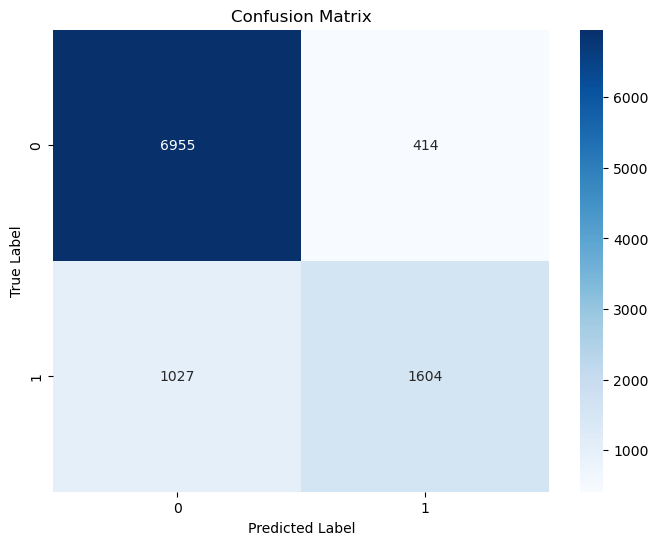

In [124]:
y_pred = gbc.predict(X_test)
accuracy_score(y_pred, y_test)

# Classification report (Precision, Recall, F1-Score)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [125]:
# Accuracy of model

print("GBC accuracy is %2.2f" % accuracy_score( 
     y_test, gbc.predict(X_test)))

from sklearn.metrics import classification_report 

pred=gbc.predict(X_test) 

print(classification_report(y_test, pred))

GBC accuracy is 0.86
              precision    recall  f1-score   support

           0       0.87      0.94      0.91      7369
           1       0.79      0.61      0.69      2631

    accuracy                           0.86     10000
   macro avg       0.83      0.78      0.80     10000
weighted avg       0.85      0.86      0.85     10000

